In [8]:
import pandas as pd
import numpy as np

# =========================
# 1) LOAD DATASETS
# =========================
demo = pd.read_sas("DEMO_J.XPT")
cbc  = pd.read_sas("CBC_J.XPT")
dbq  = pd.read_sas("DBQ_J.XPT")
rhq  = pd.read_sas("RHQ_J.XPT")
mcq  = pd.read_sas("MCQ_J.XPT")

# =========================
# 2) MERGE ON SEQN
# =========================
df = demo.merge(cbc, on="SEQN", how="inner")
df = df.merge(dbq, on="SEQN", how="left")
df = df.merge(mcq, on="SEQN", how="left")

print("Merged shape:", df.shape)

# =========================
# 3) REMOVE INCOME COLUMN
# =========================
if "INDFMPIR" in df.columns:
    df = df.drop(columns=["INDFMPIR"])

# =========================
# 4) DETECT GENDER COLUMN
# =========================
if "RIAGENDR" in df.columns:
    gender_col = "RIAGENDR"
elif "RIAGENDER" in df.columns:
    gender_col = "RIAGENDER"
else:
    raise Exception("Gender column not found!")

# =========================
# 5) CREATE ANEMIA LABEL
# =========================
def calculate_anemia(row):
    if pd.isna(row["LBXHGB"]):
        return None
    
    if row[gender_col] == 1 and row["LBXHGB"] < 13:
        return 1
    elif row[gender_col] == 2 and row["LBXHGB"] < 12:
        return 1
    else:
        return 0

df["anemia"] = df.apply(calculate_anemia, axis=1)

# =========================
# 6) SELECT ONLY RELEVANT FEATURES
# =========================
candidate_questions = [
    "RIDAGEYR",     # Age
    gender_col,     # Gender
    "RIDRETH1",     # Ethnicity
    "MCQ010",       # Diabetes
    "MCQ053",       # Hypertension
    "MCQ080",       # Heart disease
    "MCQ160A"       # Asthma
]

existing_features = [col for col in candidate_questions if col in df.columns]

# Add hemoglobin + anemia temporarily
final_features = ["SEQN"] + existing_features + ["LBXHGB", "anemia"]
df = df[final_features]

# Drop rows where anemia label is missing
df = df.dropna(subset=["anemia"])

# Drop ID and hemoglobin (prevent data leakage)
df = df.drop(columns=["SEQN", "LBXHGB"])

# =========================
# 7) CLEAN WEIRD VALUES
# =========================

# Remove extremely tiny numeric artifacts
feature_cols = [col for col in df.columns if col != "anemia"]
df[feature_cols] = df[feature_cols].mask(df[feature_cols].abs() < 1e-10)

# Replace NHANES refusal / don't know
df = df.replace({77: np.nan, 99: np.nan})

# Fill missing values using mode
for col in feature_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Final cleaned dataset shape:", df.shape)

# =========================
# SPLIT FEATURES & LABEL
# =========================
X = df.drop(columns=["anemia"])
y = df["anemia"]

# =========================
# SAVE CLEAN DATASET
# =========================
df.to_csv("anemia_questionnaire_dataset_cleaned.csv", index=False)

print("Dataset saved successfully.")


Merged shape: (8366, 187)
Final cleaned dataset shape: (7528, 8)
Dataset saved successfully.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# =========================
# 1) Split Data
# =========================
X = df.drop(columns=["anemia"])
y = df["anemia"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 2) Train Model
# =========================
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)

# Train
clf.fit(X_train, y_train)

# =========================
# Probability Predictions
# =========================
# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Apply threshold 0.4
threshold = 0.4
y_pred = (y_prob >= threshold).astype(int)

# Confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

print(f"Threshold: {threshold}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



# =========================
# 5) Feature Importance
# =========================
importances = clf.feature_importances_

for feature, importance in sorted(zip(X.columns, importances),
                                  key=lambda x: x[1],
                                  reverse=True):
    print(f"{feature}: {importance:.4f}")


Threshold: 0.4
[[832 435]
 [ 51 188]]
              precision    recall  f1-score   support

         0.0       0.94      0.66      0.77      1267
         1.0       0.30      0.79      0.44       239

    accuracy                           0.68      1506
   macro avg       0.62      0.72      0.61      1506
weighted avg       0.84      0.68      0.72      1506

RIDAGEYR: 0.5423
MCQ053: 0.1446
RIDRETH1: 0.1299
RIAGENDR: 0.1148
MCQ080: 0.0387
MCQ160A: 0.0187
MCQ010: 0.0110


In [13]:
import joblib

# Save model
joblib.dump(clf, "anemia_questionnaire_model.pkl")
print("Model saved successfully.")


Model saved successfully.


In [15]:
import pandas as pd
import joblib

# Load model
clf = joblib.load("anemia_questionnaire_model.pkl")

# Example new sample
# Make sure the columns match X_train features exactly
new_sample = pd.DataFrame([{
   "RIDAGEYR": 38,
        "RIAGENDR": 2,    # Female
        "RIDRETH1": 4,
        "MCQ010": 2,      # No diabetes
        "MCQ053": 1,      # Has hypertension
        "MCQ080": 2,      # No heart disease
        "MCQ160A": 2      # No asthma
}])

# Predict probability
prob = clf.predict_proba(new_sample)[:, 1][0]

# Apply threshold
threshold = 0.4
prediction = int(prob >= threshold)

print(f"Predicted probability of anemia: {prob:.2f}")
print(f"Anemia prediction at threshold {threshold}: {prediction}")


Predicted probability of anemia: 0.80
Anemia prediction at threshold 0.4: 1


C:\Users\Ahmed Hatem\AppData\Local\Temp\ipykernel_31276\796351120.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


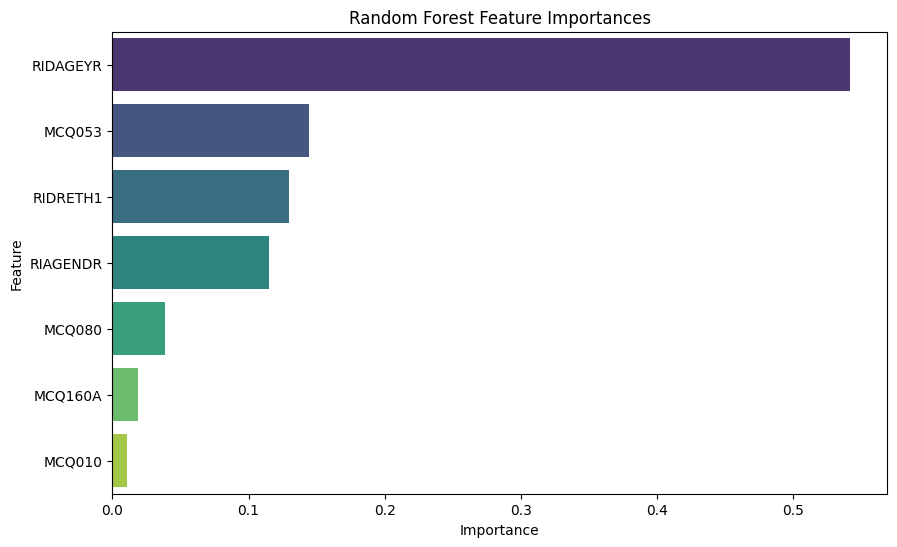

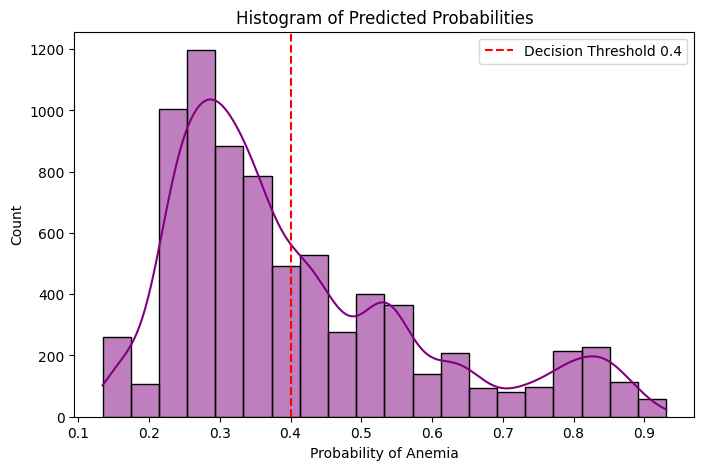

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1) Feature Importances
# =========================
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# =========================
# 2) Predicted Probabilities Histogram
# =========================
probs = clf.predict_proba(X)[:, 1]  # probability of anemia for all your data

plt.figure(figsize=(8, 5))
sns.histplot(probs, bins=20, kde=True, color="purple")
plt.axvline(0.4, color="red", linestyle="--", label="Decision Threshold 0.4")
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Probability of Anemia")
plt.ylabel("Count")
plt.legend()
plt.show()
